# 3 特徴量の重要度を知る〜Permutation Feature Importance〜

In [1]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

# 自作モジュール
sys.path.append("..")
from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

In [2]:
# シミュレーションデータも訓練データとテストデータを分けたいので
from sklearn.model_selection import train_test_split


def generate_simulation_data(N, beta, mu, Sigma):
    """線形のシミュレーションデータを生成し、訓練データとテストデータに分割する
    
    Args: 
        N: インスタンスの数
        beta: 各特徴量の傾き
        mu: 各特徴量は多変量正規分布から生成される。その平均。
        Sigma: 各特徴量は多変量正規分布から生成される。その分散共分散行列。
    """

    # 多変量正規分布からデータを生成する
    X = np.random.multivariate_normal(mu, Sigma, N)

    # ノイズは平均0標準偏差0.1(分散は0.01)で決め打ち
    epsilon = np.random.normal(0, 0.1, N)

    # 特徴量とノイズの線形和で目的変数を作成
    y = X @ beta + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータの設定
N = 1000
J = 3
mu = np.zeros(J)
Sigma = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
beta = np.array([0, 1, 2])

# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data(N, beta, mu, Sigma)

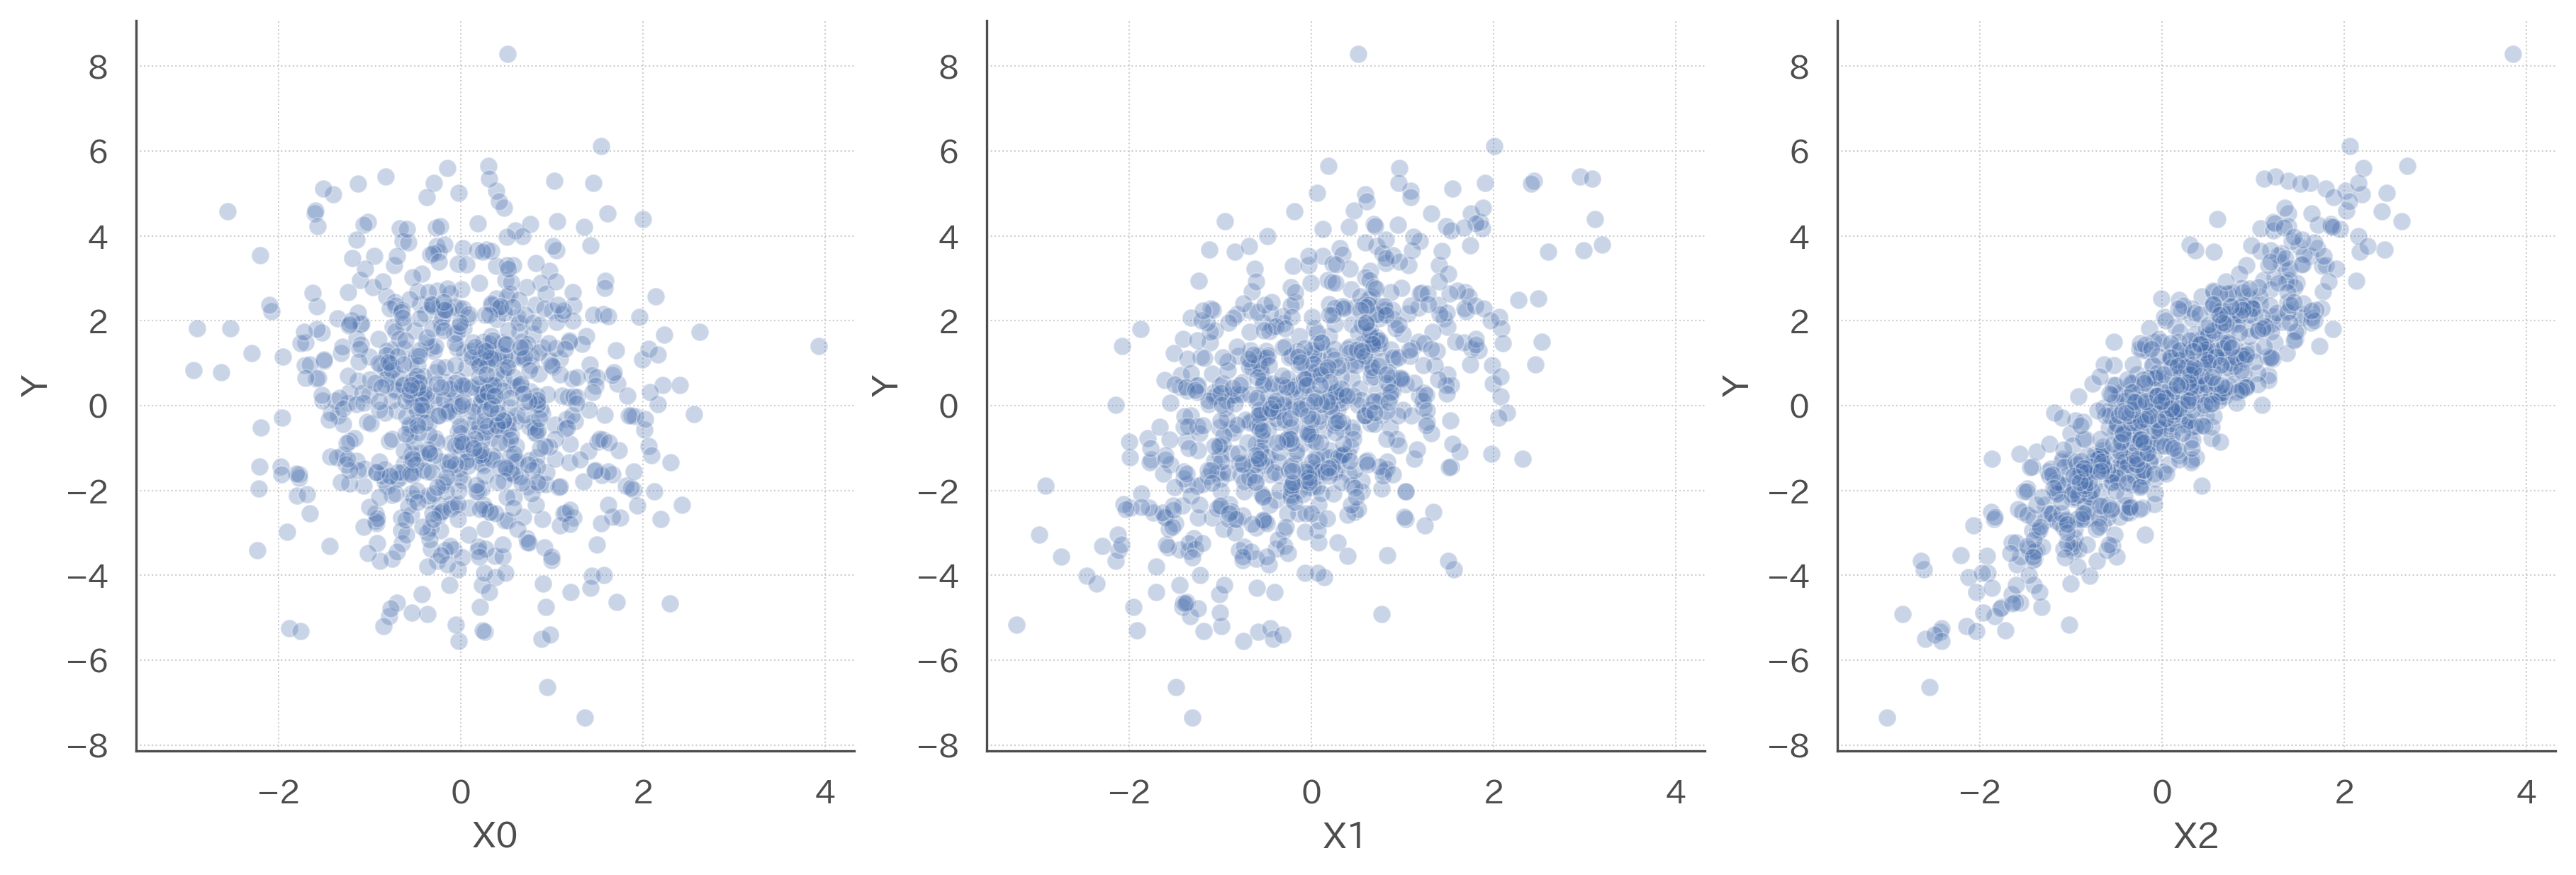

In [3]:
def plot_scatter(X, y, var_names):
    """目的変数と特徴量の散布図を作成"""

    # 特徴量の数だけ散布図を作成
    J = X.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(4 * J, 4))

    for d, ax in enumerate(axes):
        sns.scatterplot(X[:, d], y, alpha=0.3, ax=ax)
        ax.set(
            xlabel=var_names[d], 
            ylabel="Y", 
            xlim=(X.min() * 1.1, X.max() * 1.1)
        )

    fig.show()


# 可視化
var_names = [f"X{j}" for j in range(J)]
plot_scatter(X_train, y_train, var_names)

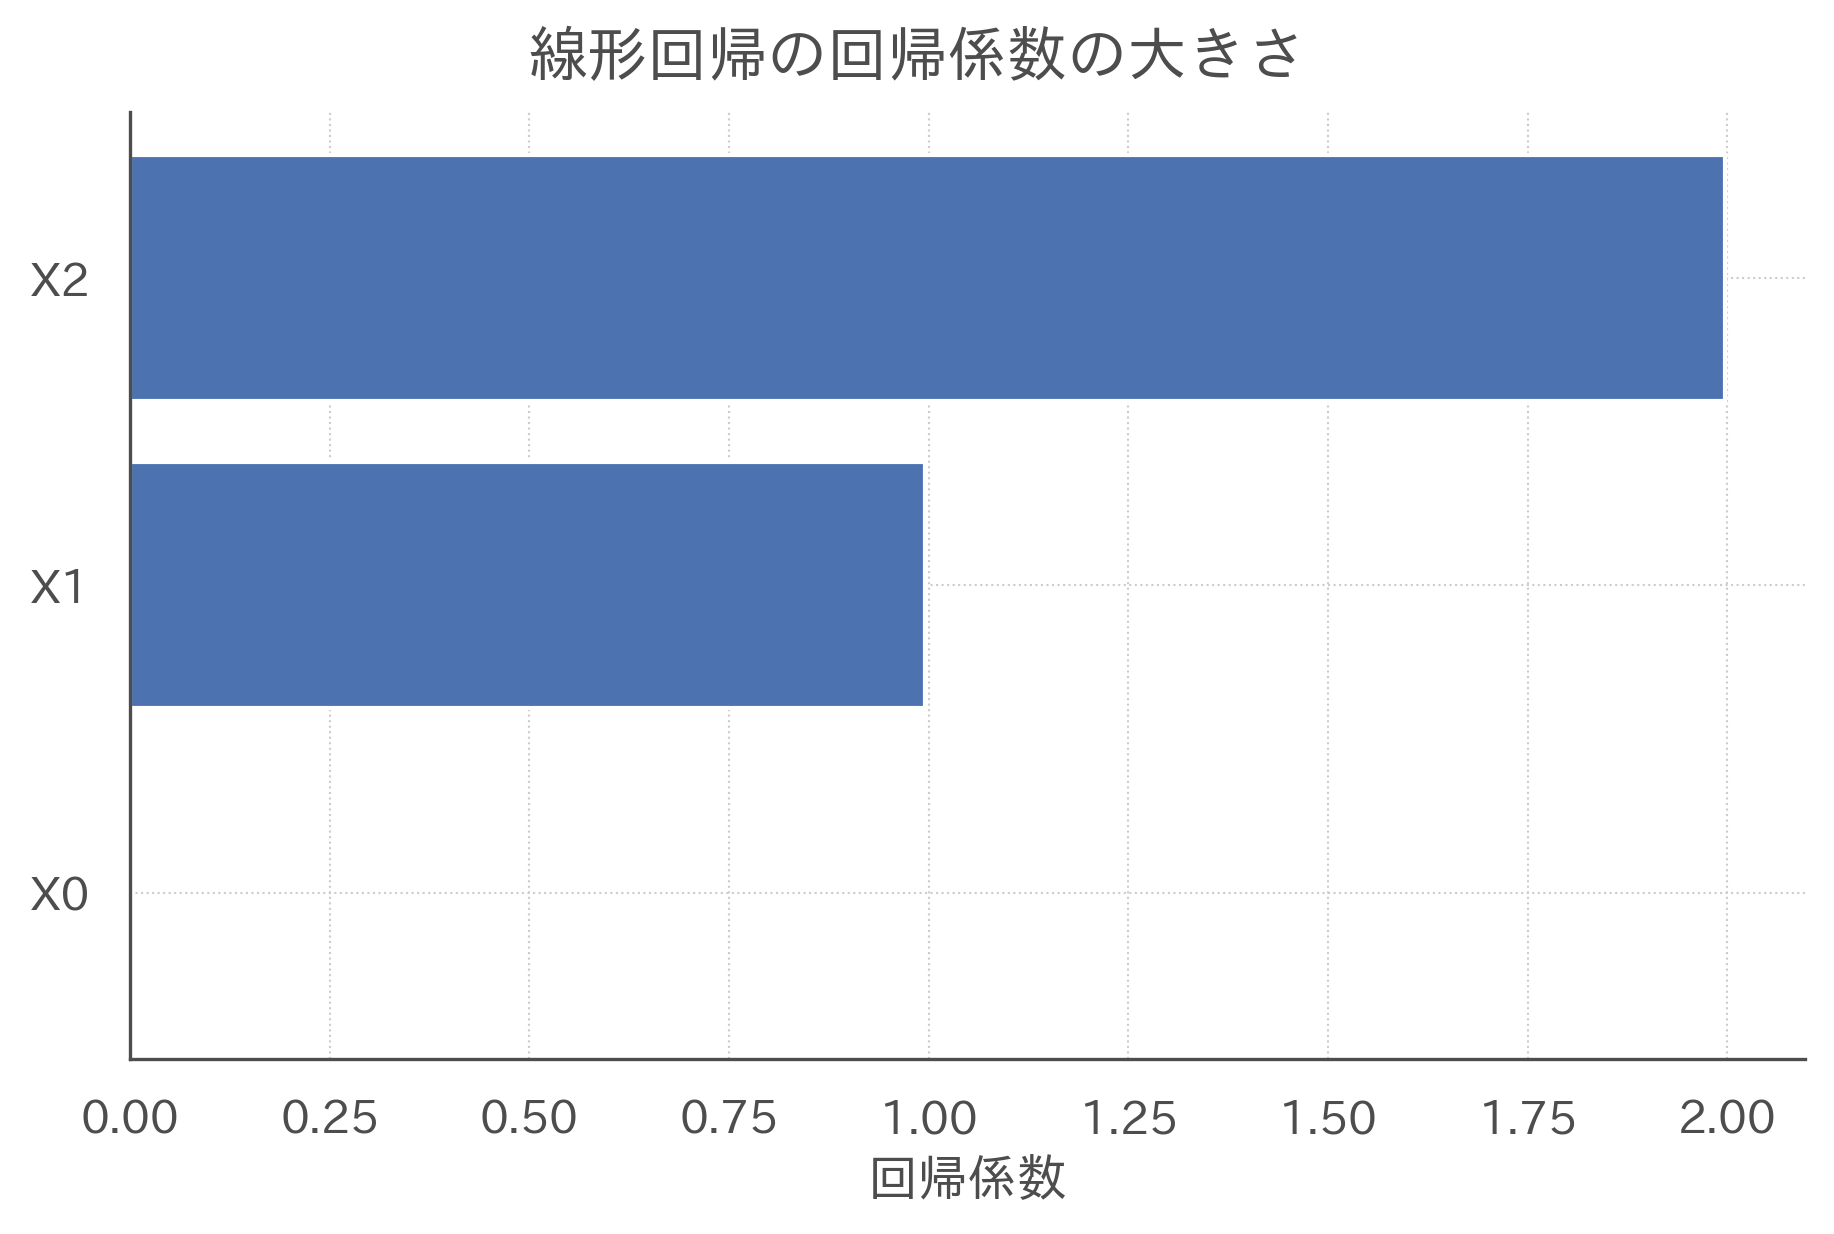

In [4]:
from sklearn.linear_model import LinearRegression


def plot_bar(variables, values, title=None, xlabel=None, ylabel=None):
    """回帰係数の大きさを確認する棒グラフを作成"""
    
    fig, ax = plt.subplots()
    ax.barh(variables, values)
    ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0, None))
    fig.suptitle(title)
    
    fig.show()


# 線形回帰モデルの学習
lm = LinearRegression().fit(X_train, y_train)

# 回帰係数の可視化
plot_bar(var_names, lm.coef_, "線形回帰の回帰係数の大きさ", "回帰係数")

In [5]:
from sklearn.metrics import mean_squared_error


@dataclass
class PermutationFeatureImportance:
    """Permutation Feature Importance (PFI)
     
    Args:
        estimator: 全特徴量を用いた学習済みモデル
        X: 特徴量
        y: 目的変数
        var_names: 特徴量の名前
    """
    
    estimator: Any
    X: np.ndarray
    y: np.ndarray
    var_names: list[str]
        
    def __post_init__(self) -> None:
        # シャッフルなしの場合の予測精度
        # mean_squared_error()はsquared=TrueならMSE、squared=FalseならRMSE
        self.baseline = mean_squared_error(
            self.y, self.estimator.predict(self.X), squared=False
        )

    def _permutation_metrics(self, idx_to_permute: int) -> float:
        """ある特徴量の値をシャッフルしたときの予測精度を求める

        Args:
            idx_to_permute: シャッフルする特徴量のインデックス
        """

        # シャッフルする際に、元の特徴量が上書きされないよう用にコピーしておく
        X_permuted = self.X.copy()

        # 特徴量の値をシャッフルして予測
        X_permuted[:, idx_to_permute] = np.random.permutation(
            X_permuted[:, idx_to_permute]
        )
        y_pred = self.estimator.predict(X_permuted)

        return mean_squared_error(self.y, y_pred, squared=False)

    def permutation_feature_importance(self, n_shuffle: int = 10) -> None:
        """PFIを求める

        Args:
            n_shuffle: シャッフルの回数。多いほど値が安定する。デフォルトは10回
        """

        J = self.X.shape[1]  # 特徴量の数

        # J個の特徴量に対してPFIを求めたい
        # R回シャッフルを繰り返して平均をとることで値を安定させている
        metrics_permuted = [
            np.mean(
                [self._permutation_metrics(j) for r in range(n_shuffle)]
            )
            for j in range(J)
        ]

        # データフレームとしてまとめる
        # シャッフルでどのくらい予測精度が落ちるかは、
        # 差(difference)と比率(ratio)の2種類を用意する
        df_feature_importance = pd.DataFrame(
            data={
                "var_name": self.var_names,
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted / self.baseline,
            }
        )

        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
        )

    def plot(self, importance_type: str = "difference") -> None:
        """PFIを可視化

        Args:
            importance_type: PFIを差(difference)と比率(ratio)のどちらで計算するか
        """

        fig, ax = plt.subplots()
        ax.barh(
            self.feature_importance["var_name"],
            self.feature_importance[importance_type],
            label=f"baseline: {self.baseline:.2f}",
        )
        ax.set(xlabel=importance_type, ylabel=None)
        ax.invert_yaxis() # 重要度が高い順に並び替える
        ax.legend(loc="lower right")
        fig.suptitle(f"Permutationによる特徴量の重要度({importance_type})")
        
        fig.show()

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Random Forestの予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

In [7]:
from sklearn.metrics import r2_score

# 予測精度を確認
print(f"R2: {r2_score(y_test, rf.predict(X_test)):.2f}")

R2: 0.99


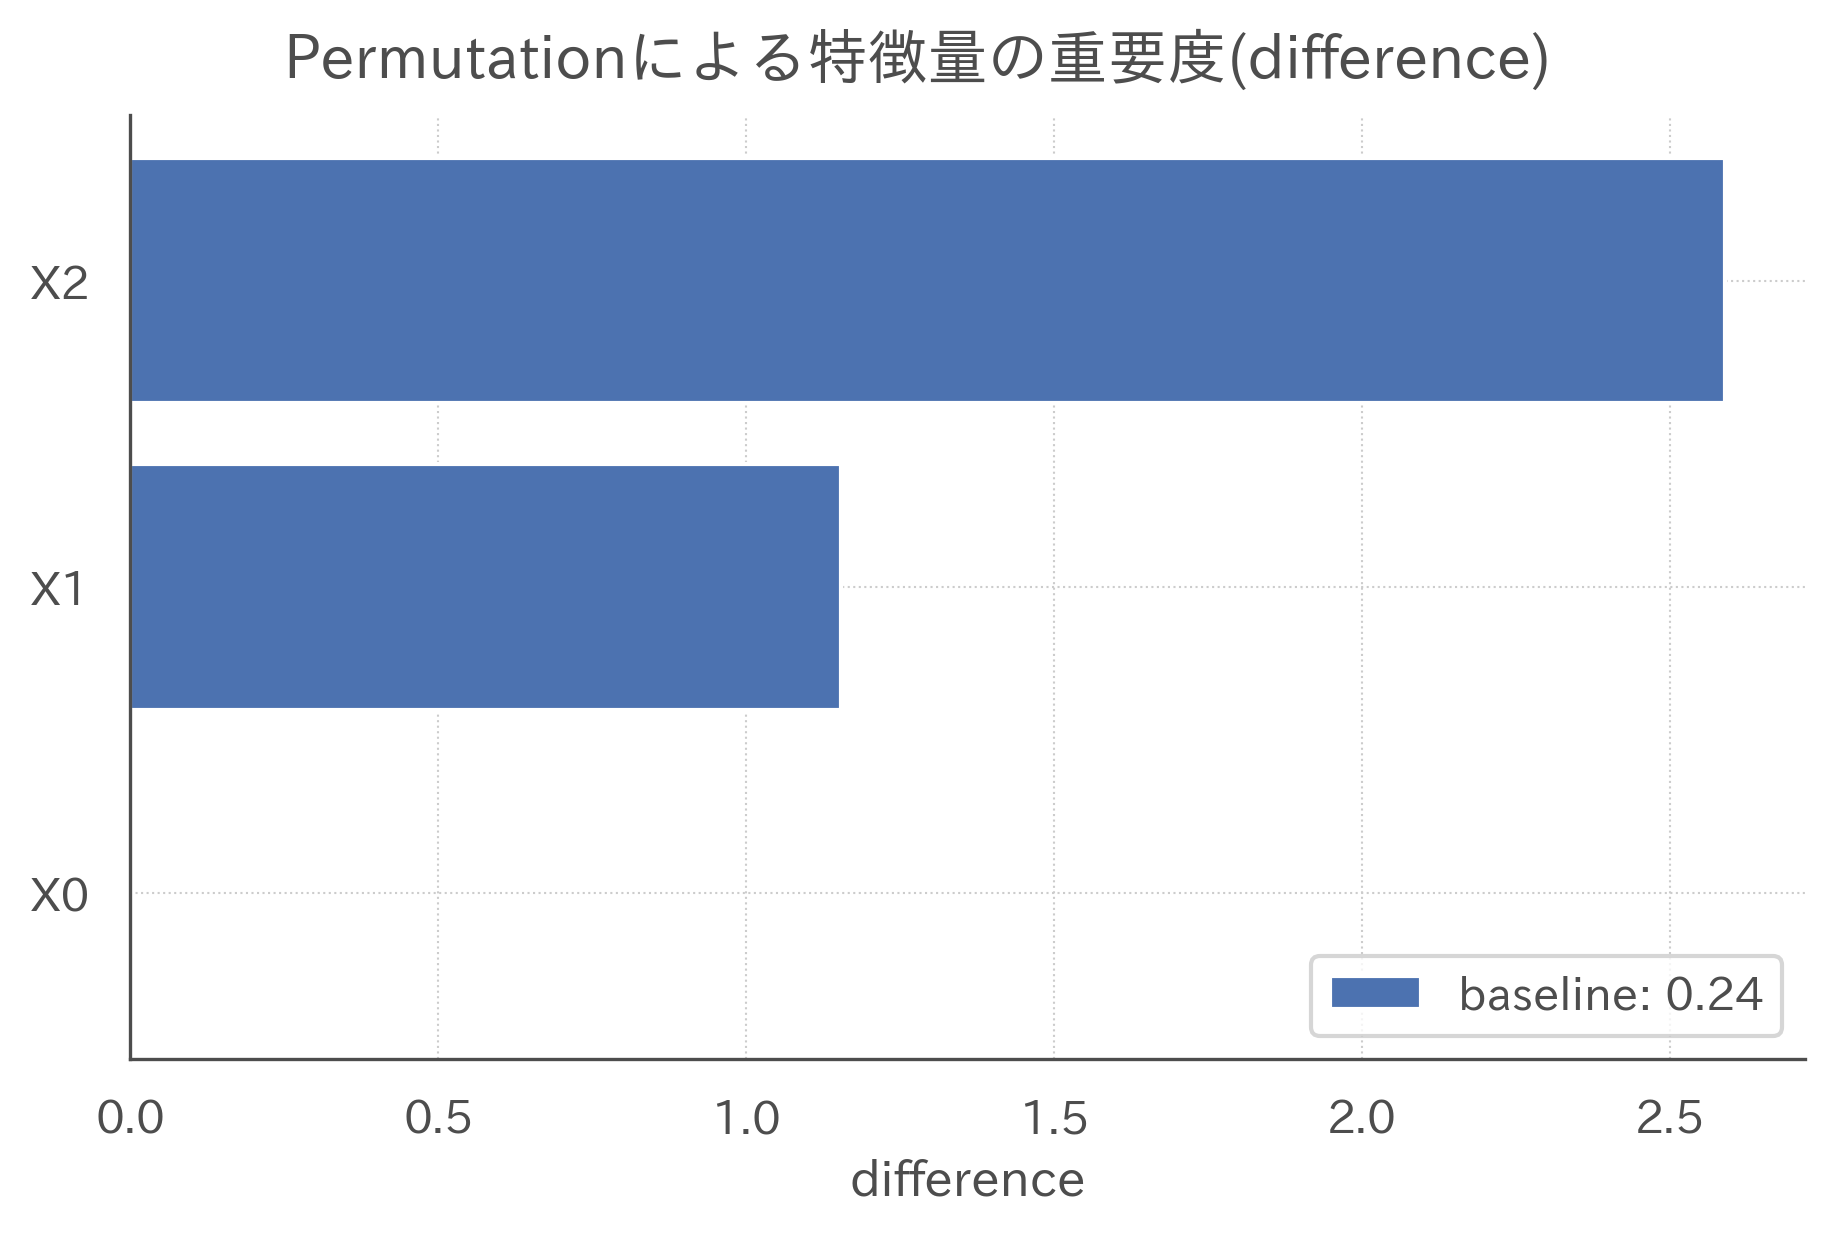

In [8]:
# PFIを計算して可視化
# PFIのインスタンスの作成
pfi = PermutationFeatureImportance(rf, X_test, y_test, var_names)

# PFIを計算
pfi.permutation_feature_importance()

# PFIを可視化
pfi.plot(importance_type="difference")

In [9]:
class GroupedPermutationFeatureImportance(PermutationFeatureImportance):
    """Grouped Permutation Feature Importance (GPFI)"""

    def _permutation_metrics(
        self,
        var_names_to_permute: list[str]
    ) -> float:
        """ある特徴量群の値をシャッフルしたときの予測精度を求める

        Args:
            var_names_to_permute: シャッフルする特徴量群の名前
        """

        # シャッフルする際に、元の特徴量が上書きされないよう用にコピーしておく
        X_permuted = self.X.copy()

        # 特徴量名をインデックスに変換
        idx_to_permute = [
            self.var_names.index(v) for v in var_names_to_permute
        ]

        # 特徴量群をまとめてシャッフルして予測
        X_permuted[:, idx_to_permute] = np.random.permutation(
            X_permuted[:, idx_to_permute]
        )
        y_pred = self.estimator.predict(X_permuted)

        return mean_squared_error(self.y, y_pred, squared=False)

    def permutation_feature_importance(
        self,
        var_groups: list[list[str]] | None = None,
        n_shuffle: int = 10
    ) -> None:
        """GPFIを求める

        Args:
            var_groups:
                グループ化された特徴量名のリスト。例：[['X0', 'X1'], ['X2']]
                Noneを指定すれば通常のPFIが計算される
            n_shuffle:
                シャッフルの回数。多いほど値が安定する。デフォルトは10回
        """

        # グループが指定されなかった場合は1つの特徴量を1グループとする。PFIと同じ。
        if var_groups is None:
            var_groups = [[j] for j in self.var_names]

        # グループごとに重要度を計算
        # R回シャッフルを繰り返して値を安定させている
        metrics_permuted = [
            np.mean(
                [self._permutation_metrics(j) for r in range(n_shuffle)]
            )
            for j in var_groups
        ]

        # データフレームとしてまとめる
        # シャッフルでどのくらい予測精度が落ちるかは、差と比率の2種類を用意する
        df_feature_importance = pd.DataFrame(
            data={
                "var_name": ["+".join(j) for j in var_groups],
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted / self.baseline,
            }
        )

        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
        )

In [10]:
# 特徴量X2と全く同じ特徴量を追加
X_train2 = np.concatenate([X_train, X_train[:, [2]]], axis=1)

In [11]:
# 特徴量X2と全く同じ特徴量を追加した新しいデータからRandom Forestの予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train2, y_train)

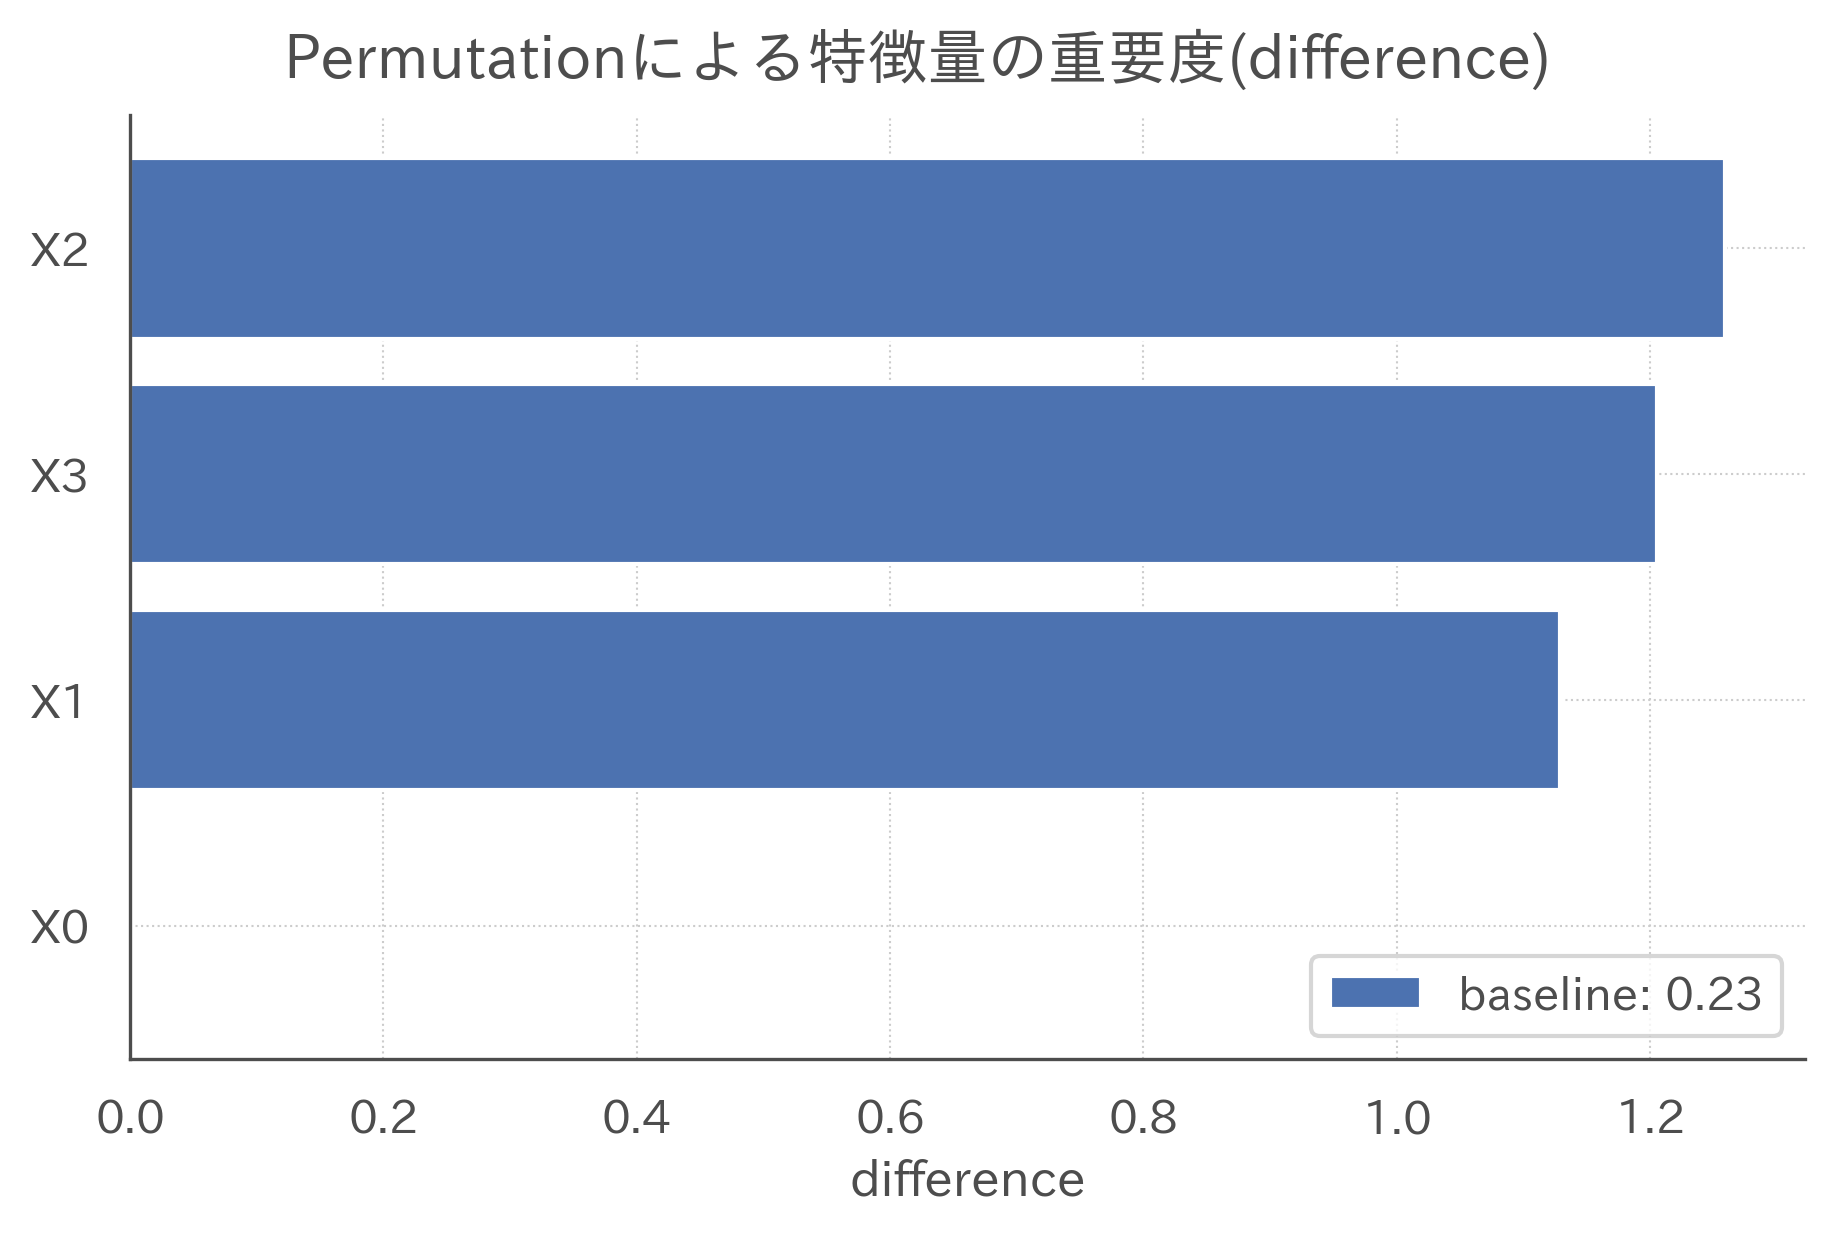

In [12]:
# テストデータにも同様に特徴量X2とまったく同じ値をとる特徴量X3を作る。
X_test2 = np.concatenate([X_test, X_test[:, [2]]], axis=1)

gpfi = GroupedPermutationFeatureImportance(
    rf, X_test2, y_test, ["X0", "X1", "X2", "X3"]
)

# var_groupsを指定しなければ通常のPFIが計算される
gpfi.permutation_feature_importance()

# 可視化
gpfi.plot()

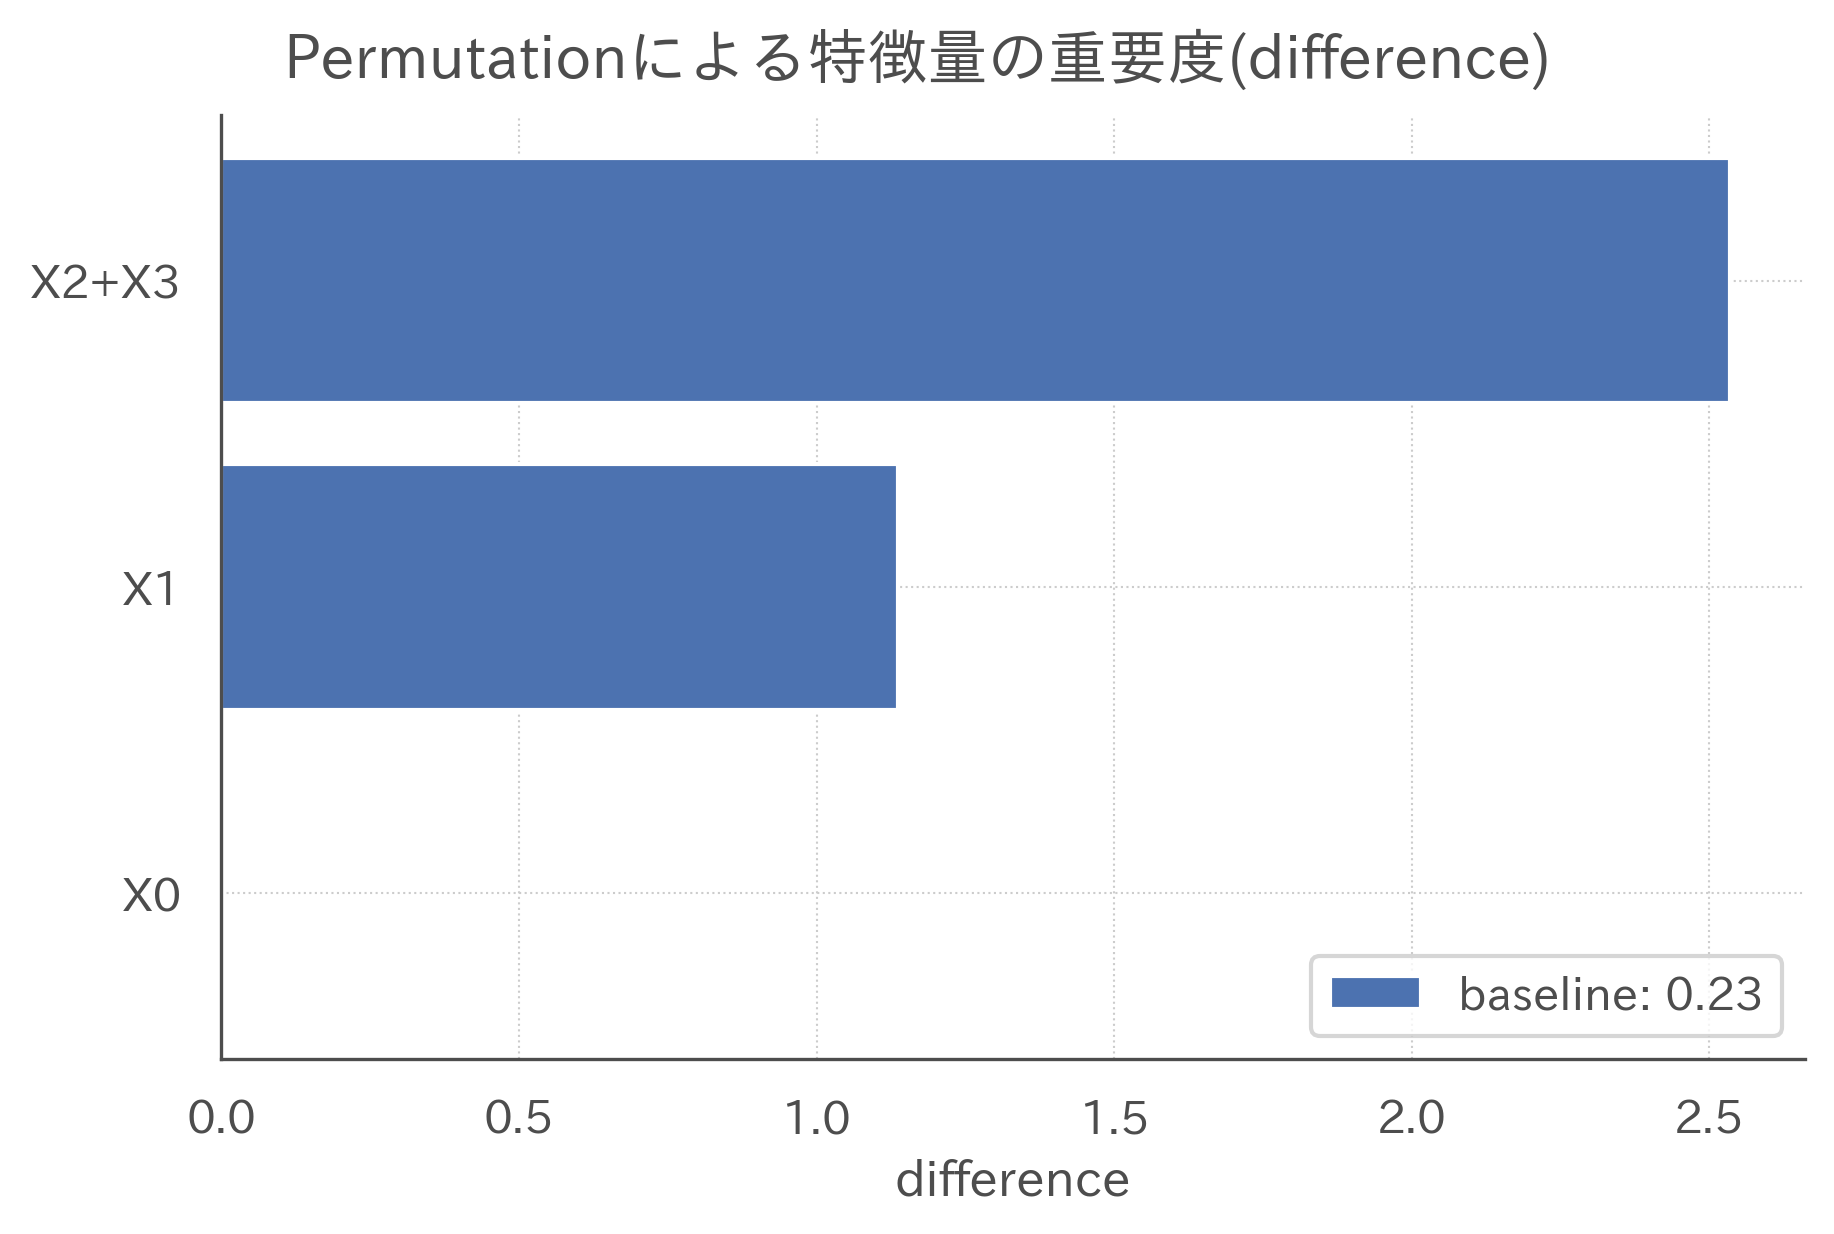

In [13]:
# X2とX3はまとめてシャッフル。X0とX1は個別にシャッフル
gpfi.permutation_feature_importance(var_groups=[["X0"], ["X1"], ["X2", "X3"]])

# GPFIを可視化
gpfi.plot()

In [14]:
# シミュレーションデータの設定
N = 1000
J = 3
mu = np.zeros(J)
Sigma = np.array([[1, 0.95, 0], [0.95, 1, 0], [0, 0, 1]])
beta = np.array([1, 0, 0])

# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data(N, beta, mu, Sigma)

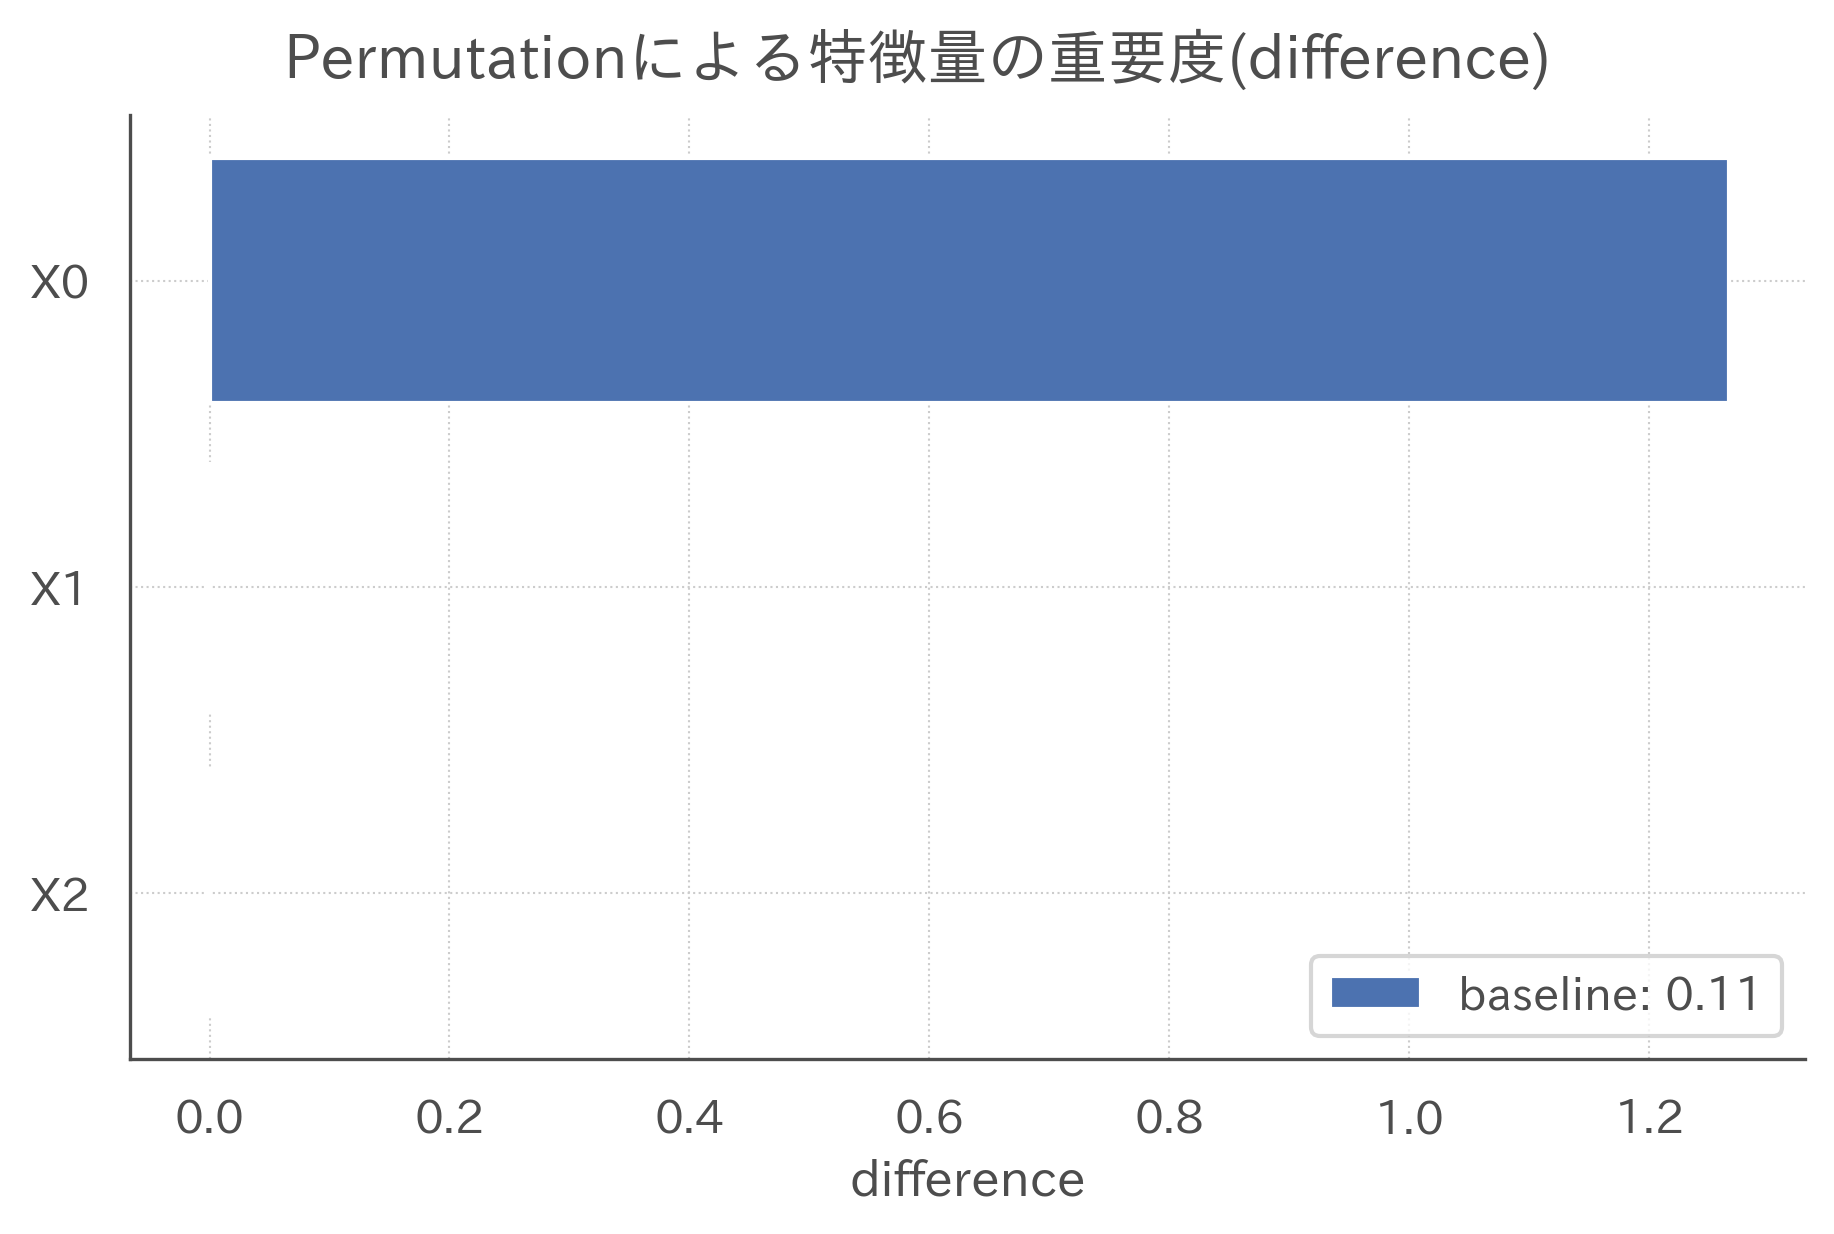

In [15]:
# 全特徴量を使ってRandom Forestの予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# PFIを計算
pfi = PermutationFeatureImportance(rf, X_test, y_test, var_names)
pfi.permutation_feature_importance()

# PFIを可視化
pfi.plot(importance_type="difference")

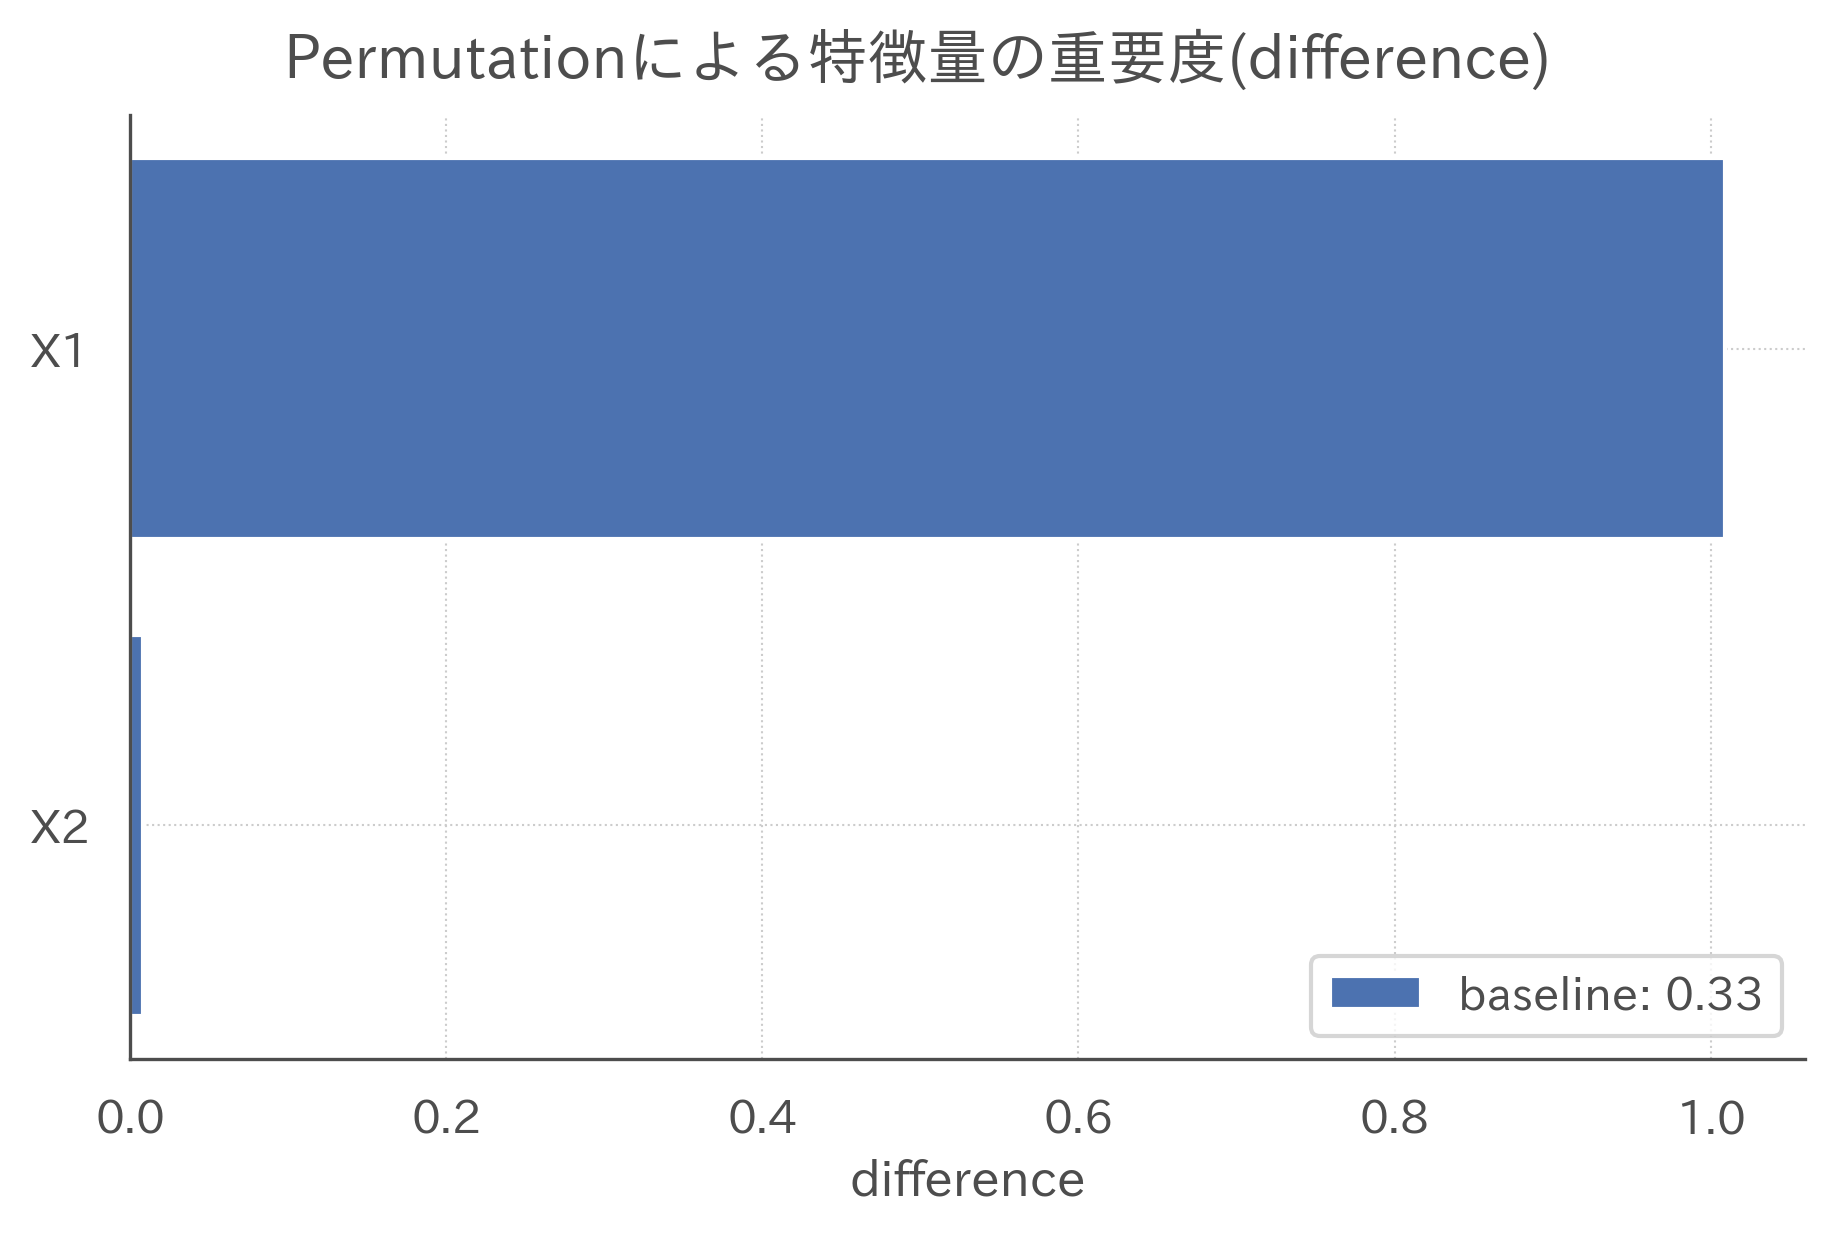

In [16]:
# # X0は使わずRandom Forestの予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train[:, [1, 2]], y_train)

# PFIを計算。X0は使わない
pfi = PermutationFeatureImportance(rf, X_test[:, [1, 2]], y_test, ["X1", "X2"])
pfi.permutation_feature_importance()

# PFIを可視化
pfi.plot(importance_type="difference")

In [17]:
import joblib

# データと学習済みモデルを読み込む
X_train, X_test, y_train, y_test = joblib.load("../data/boston_housing.pkl")
rf = joblib.load("../model/boston_housing_rf.pkl")

In [18]:
from sklearn.inspection import permutation_importance

# PFIを計算
pfi = permutation_importance(
    estimator=rf,
    X=X_test,
    y=y_test,
    scoring="neg_root_mean_squared_error",  # 評価指標はRMSEを指定
    n_repeats=5,  # シャッフルの回数
    n_jobs=-1,
    random_state=42,
)

pfi

{'importances_mean': array([0.47335366, 0.00767681, 0.0488425 , 0.00577725, 0.39998356,
        3.71527662, 0.17887136, 0.94838591, 0.0314633 , 0.11882726,
        0.2915789 , 0.02083006, 3.54059205]),
 'importances_std': array([0.0364208 , 0.00788286, 0.01233191, 0.00195267, 0.04552138,
        0.10845402, 0.03142234, 0.51582081, 0.00712065, 0.03561518,
        0.05189719, 0.03750401, 0.55511839]),
 'importances': array([[ 4.21780470e-01,  4.47578199e-01,  5.24408599e-01,
          4.73160410e-01,  4.99840633e-01],
        [ 3.82160776e-03,  1.44580414e-02,  1.84218654e-02,
          5.36588658e-03, -3.68333178e-03],
        [ 4.75590731e-02,  5.98691482e-02,  6.53492096e-02,
          3.25437839e-02,  3.88913056e-02],
        [ 8.44613611e-03,  3.60372142e-03,  7.20979226e-03,
          3.52744355e-03,  6.09918045e-03],
        [ 3.70942819e-01,  3.32201627e-01,  4.57748542e-01,
          4.39806226e-01,  3.99218573e-01],
        [ 3.71381796e+00,  3.83244494e+00,  3.53957912e+00,
  

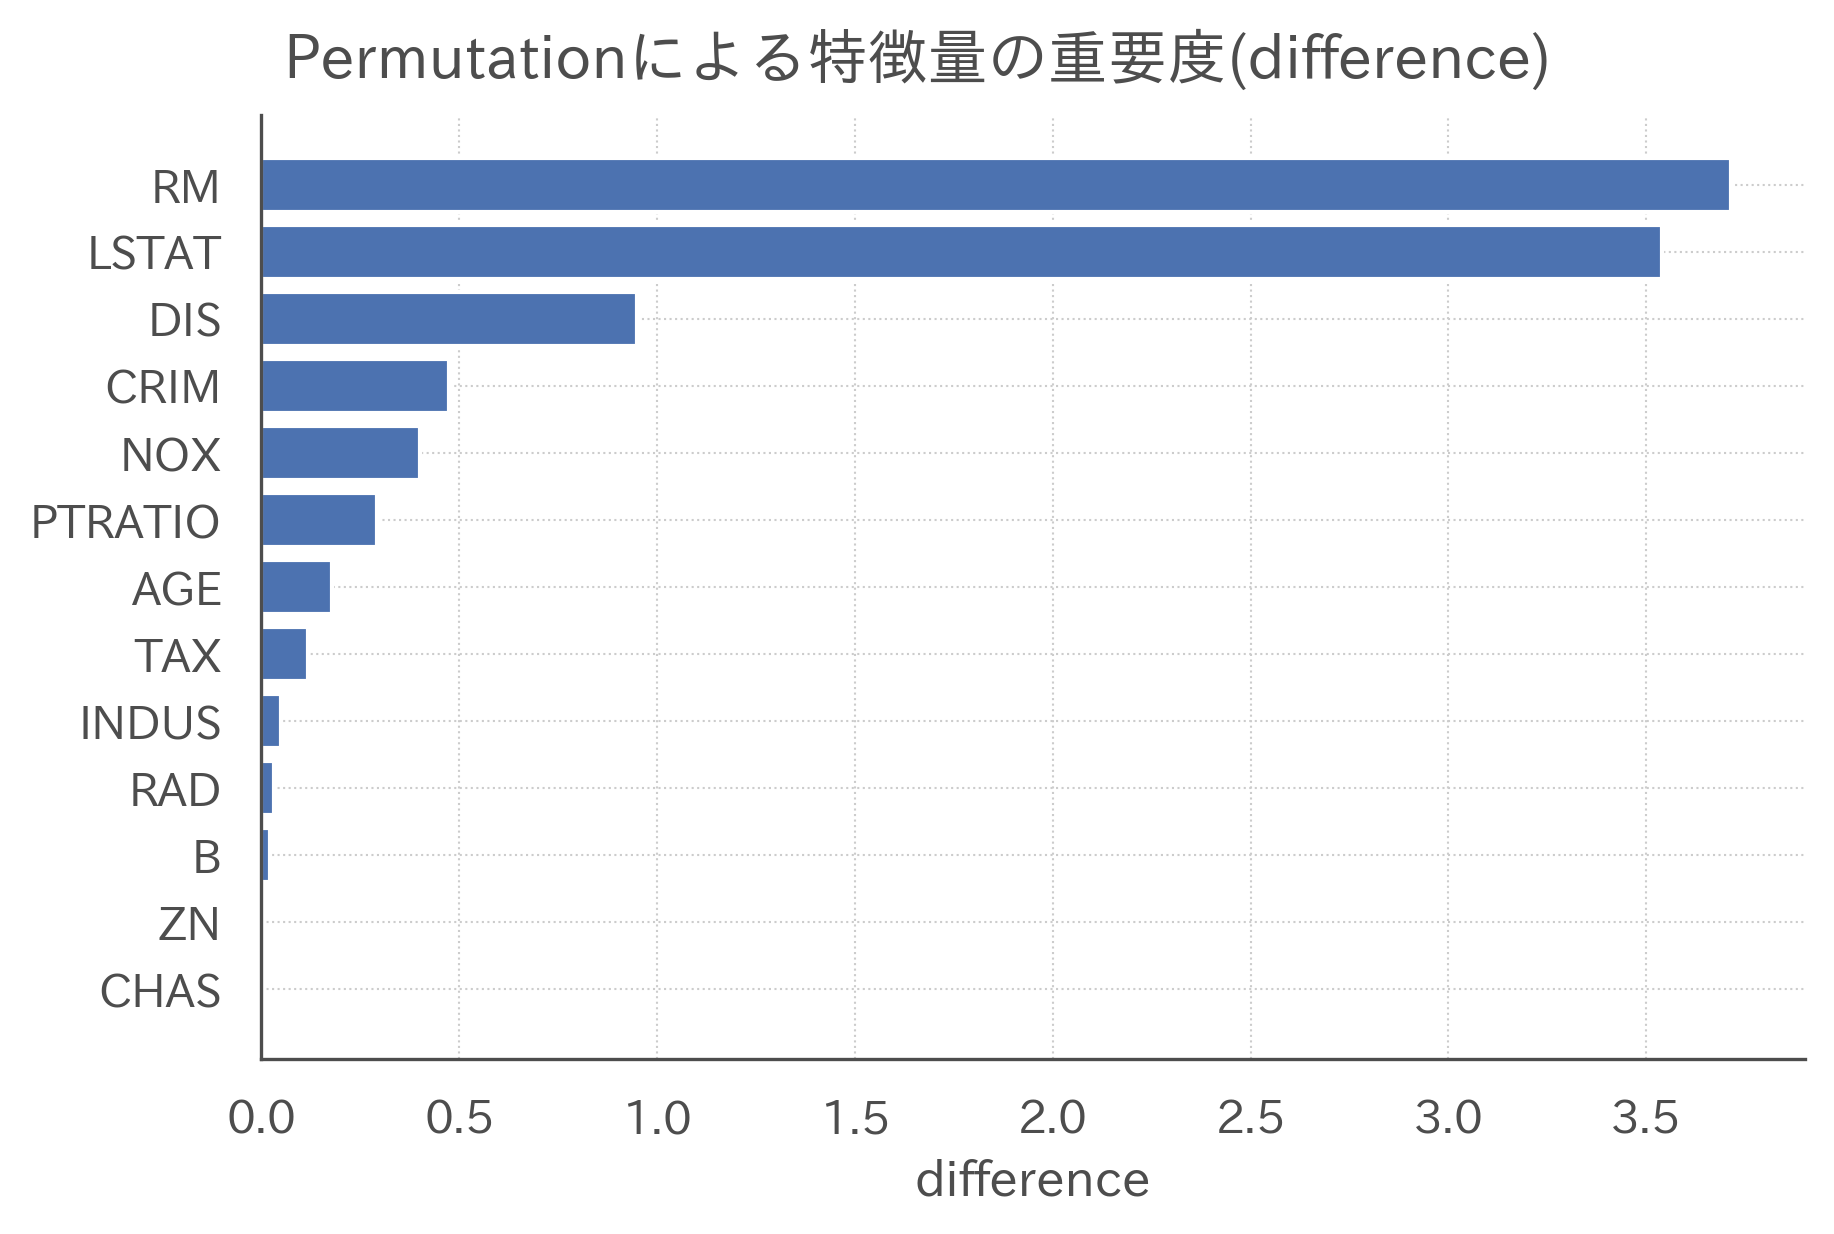

In [19]:
# PFIを可視化するために、特徴量の名前と重要度を対応させたデータフレームを作成
df_pfi = pd.DataFrame(
    data={"var_name": X_test.columns, "importance": pfi["importances_mean"]}
).sort_values("importance")

# PFIを可視化
plot_bar(
    df_pfi["var_name"],
    df_pfi["importance"],
    xlabel="difference",
    title="Permutationによる特徴量の重要度(difference)",
)